## Inference on Local Dekstop

In [1]:
import tensorflow as tf
import os
import cv2
import math
import numpy as np
import pandas as pd
import time

from PIL import Image
from sklearn.metrics import roc_curve, auc
from openvino.inference_engine import IECore

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
model_filepath = "masked_face_classifier.pb"
path_no_mask = 'masked-face-image-classification/image_classification_dataset_96_split_trainvaltest/{}/0/'
path_mask = 'masked-face-image-classification/image_classification_dataset_96_split_trainvaltest/{}/1/'

### 1. Generate Test Dataset

In [3]:
image_list = []
for t in ['train', 'test', 'val']:
    path = path_no_mask.format(t)
    for i in os.listdir(path):
        image_list.append((path, i, 0))

for t in ['train', 'test', 'val']:
    path = path_mask.format(t)
    for i in os.listdir(path):
        image_list.append((path, i, 1))

### 2.a. Inference using tensorflow pipeline batch 1

In [5]:
names = []
labels = []
scores = []
duration = []

with tf.gfile.GFile(model_filepath, "rb") as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())

    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def,
                            input_map=None,
                            return_elements=None,
                            name="")
        
        image_tensor = graph.get_tensor_by_name("mobilenetv2_1.00_96_input:0")
        classification_scores = graph.get_tensor_by_name("classification_scores:0")
        
        with tf.Session(graph=graph) as sess:
            
            for path,name,label in image_list:
                img = cv2.imread(path + name)
                img = img/255
                img = np.expand_dims(img, axis=0)

                start = time.time()
                result = sess.run(classification_scores, feed_dict={image_tensor: img})
                end = time.time()
                
                names.append(name)
                scores.append(result[0][0])
                labels.append(label)
                duration.append(end-start)

print("FPS for inference using pb with 1 batch is {}.".format(str(1/np.median(duration))))
                

FPS for inference using pb with 1 batch is 117.7084163556254.


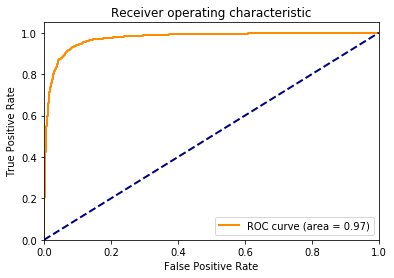

In [6]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(labels, scores)
    roc_auc[i] = auc(fpr[i], tpr[i])

lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### 2.b. Inference using openvino pipeline batch 1

In [7]:
from openvino.inference_engine import IECore

In [8]:
model_xml = "batch_1/masked_face_classifier.xml"
model_bin = "batch_1/masked_face_classifier.bin"

cpu_extension_path = os.path.expanduser("~")+"/inference_engine_samples/intel64/Release/lib/libcpu_extension.so"

device = "CPU"

report_top_n = 10

print("Configuration parameters settings:"
     "\n\tmodel_xml=", model_xml,
      "\n\tmodel_bin=", model_bin,
      "\n\tdevice=", device, 
      "\n\treport_top_n=", report_top_n)

# create Inference Engine instance
ie = IECore()
print("An Inference Engine object has been created")

# load network from IR files
net = ie.read_network(model=model_xml, weights=model_bin)
print("Loaded model IR files [",model_bin,"] and [", model_xml, "]\n")

# check to make sure that the plugin has support for all layers in the loaded model
supported_layers = ie.query_network(net,device)
not_supported_layers = [l for l in net.layers.keys() if l not in supported_layers]
if len(not_supported_layers) != 0:
    print("ERROR: Following layers are not supported by the plugin for specified",
          " device {}:\n {}".format(device, ', '.join(not_supported_layers)))
    assert 0 == 1, "ERROR: Missing support for all layers in the model," \
               + " cannot continue."

# check to make sue that the model's input and output are what is expected
assert len(net.inputs.keys()) == 1, \
    "ERROR: This sample supports only single input topologies"
assert len(net.outputs) == 1, \
    "ERROR: This sample supports only single output topologies"
print("SUCCESS: Model IR files have been loaded and verified")

exec_net = ie.load_network(network=net, num_requests=2, device_name=device)

# store name of input and output blobs
input_blob = next(iter(net.inputs))

# read the input's dimensions: n=batch size, c=number of channels, h=height, w=width
n, c, h, w = net.inputs[input_blob].shape
print("Loaded model into Inference Engine for device:", device, 
      "\nModel input dimensions: n=",n,", c=",c,", h=",h,", w=",w)

names = []
labels = []
scores = []
duration = []

for path,name,label in image_list:
    img = cv2.imread(path + name)
    img = img/255
    img = img.transpose((2, 0, 1)) 
    img = np.expand_dims(img, axis=0)

    start = time.time()
    result = exec_net.infer(inputs={input_blob: img})
    end = time.time()

    names.append(name)
    scores.append(result['activation/Sigmoid'][0][0])
    labels.append(label)
    duration.append(end-start)
    
print("FPS for inference using pb with 1 batch is {}.".format(str(1/np.median(duration))))


Configuration parameters settings:
	model_xml= batch_1/masked_face_classifier.xml 
	model_bin= batch_1/masked_face_classifier.bin 
	device= CPU 
	report_top_n= 10
An Inference Engine object has been created
Loaded model IR files [ batch_1/masked_face_classifier.bin ] and [ batch_1/masked_face_classifier.xml ]

SUCCESS: Model IR files have been loaded and verified
Loaded model into Inference Engine for device: CPU 
Model input dimensions: n= 1 , c= 3 , h= 96 , w= 96
FPS for inference using pb with 1 batch is 512.8137914170436.


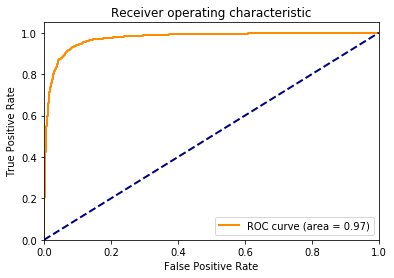

In [9]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(labels, scores)
    roc_auc[i] = auc(fpr[i], tpr[i])

lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### 3.a Inference using tensorflow pipeline batch 32

In [12]:
batch = 32
names = []
labels = []
scores = []
duration = []
with tf.gfile.GFile(model_filepath, "rb") as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())

    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def,
                            input_map=None,
                            return_elements=None,
                            name="")
        
        image_tensor = graph.get_tensor_by_name("mobilenetv2_1.00_96_input:0")
        classification_scores = graph.get_tensor_by_name("classification_scores:0")
        
        with tf.Session(graph=graph) as sess:
            img_batch = []
            name_tmp = []
            label_tmp = []
            
            for path,name,label in image_list:
                img = cv2.imread(path + name)
                img = img/255
                img_batch.append(img)
                name_tmp.append(name)
                label_tmp.append(label)
                
                if len(img_batch) == batch:
                    img = np.array(img_batch)
                    start = time.time()
                    result = sess.run(classification_scores, feed_dict={image_tensor: img})
                    end = time.time()
                    
                    names += name_tmp
                    scores += list(result[:, 0])
                    labels += label_tmp
                    duration += [(end-start)/batch] * batch
                    img_batch = []
                    name_tmp = []
                    label_tmp = []
            
            if len(img_batch) == len(image_list)%batch:
                img = np.array(img_batch)
                start = time.time()
                result = sess.run(classification_scores, feed_dict={image_tensor: img})
                end = time.time()
                
                names += name_tmp
                scores += list(result[:, 0])
                labels += label_tmp
                duration += [(end-start)/batch] * batch

print("FPS for inference using pb with 32 batch is {}.".format(str(1/np.median(duration))))


FPS for inference using pb with 32 batch is 216.03576513157208.


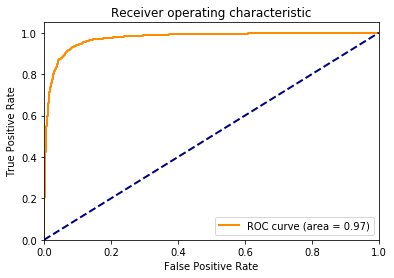

In [13]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(labels, scores)
    roc_auc[i] = auc(fpr[i], tpr[i])

lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### 3.b. Inference using openvino pipeline batch 32

In [14]:
model_xml = "batch_32/masked_face_classifier.xml"
model_bin = "batch_32/masked_face_classifier.bin"

cpu_extension_path = os.path.expanduser("~")+"/inference_engine_samples/intel64/Release/lib/libcpu_extension.so"

device = "CPU"

report_top_n = 10

print("Configuration parameters settings:"
     "\n\tmodel_xml=", model_xml,
      "\n\tmodel_bin=", model_bin,
      "\n\tdevice=", device, 
      "\n\treport_top_n=", report_top_n)

# create Inference Engine instance
ie = IECore()
print("An Inference Engine object has been created")

# load network from IR files
net = ie.read_network(model=model_xml, weights=model_bin)
print("Loaded model IR files [",model_bin,"] and [", model_xml, "]\n")

# check to make sure that the plugin has support for all layers in the loaded model
supported_layers = ie.query_network(net,device)
not_supported_layers = [l for l in net.layers.keys() if l not in supported_layers]
if len(not_supported_layers) != 0:
    print("ERROR: Following layers are not supported by the plugin for specified",
          " device {}:\n {}".format(device, ', '.join(not_supported_layers)))
    assert 0 == 1, "ERROR: Missing support for all layers in the model," \
               + " cannot continue."

# check to make sue that the model's input and output are what is expected
assert len(net.inputs.keys()) == 1, \
    "ERROR: This sample supports only single input topologies"
assert len(net.outputs) == 1, \
    "ERROR: This sample supports only single output topologies"
print("SUCCESS: Model IR files have been loaded and verified")

exec_net = ie.load_network(network=net, num_requests=2, device_name=device)

# store name of input and output blobs
input_blob = next(iter(net.inputs))

# read the input's dimensions: n=batch size, c=number of channels, h=height, w=width
n, c, h, w = net.inputs[input_blob].shape
print("Loaded model into Inference Engine for device:", device, 
      "\nModel input dimensions: n=",n,", c=",c,", h=",h,", w=",w)

labels_map = ['Wearing Mask', 'Not Wearing Mask']

batch = 32
scores = []
img_batch = []
labels = []
duration = []
label_tmp = []

mod_img = len(image_list)%batch
for path,name,label in image_list:
    img = cv2.imread(path + name)
    img = img/255
    img = img.transpose((2, 0, 1)) 
    img_batch.append(img)
    label_tmp.append(label)

    if len(img_batch) == batch:
        img = np.array(img_batch)
        start = time.time()
        result = exec_net.infer(inputs={input_blob: img})
        end = time.time()
        
        scores += list(result['activation/Sigmoid'][:,0])
        labels += label_tmp
        duration += [(end-start)/batch] * batch
        img_batch = []
        label_tmp = []

if len(img_batch) == mod_img:
    img = np.array(img_batch)
    tmp = np.zeros([batch-mod_img, 3, 96, 96])
    img = np.concatenate([img, tmp], axis=0)
    start = time.time()
    result = exec_net.infer(inputs={input_blob: img})
    end = time.time()
    
    scores += list(result['activation/Sigmoid'][:mod_img,0])
    labels += label_tmp
    duration += [(end-start)/batch] * batch

print("FPS for inference using openvino with 32 batch is {}.".format(str(1/np.median(duration))))


Configuration parameters settings:
	model_xml= batch_32/masked_face_classifier.xml 
	model_bin= batch_32/masked_face_classifier.bin 
	device= CPU 
	report_top_n= 10
An Inference Engine object has been created
Loaded model IR files [ batch_32/masked_face_classifier.bin ] and [ batch_32/masked_face_classifier.xml ]

SUCCESS: Model IR files have been loaded and verified
Loaded model into Inference Engine for device: CPU 
Model input dimensions: n= 32 , c= 3 , h= 96 , w= 96
FPS for inference using openvino with 32 batch is 829.2979579227039.


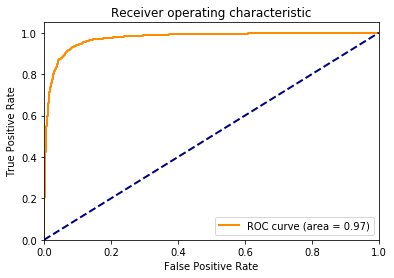

In [15]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(labels, scores)
    roc_auc[i] = auc(fpr[i], tpr[i])

lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()